#  Sentiment Analysis with TF-IDF and Logistic Regression

**Sentiment analysis** (or opinion mining) is a natural language processing technique used to determine whether data is positive, negative or neutral.

**Sentiment analysis** is often performed on textual data to help businesses monitor brand and product sentiment in customer feedback, and understand customer needs.

## Data Exploration

In [3]:
import pandas as pd
import numpy as np

data = pd.read_csv("drive/implementation/orange_MLA/Tweets/Tweets.csv")
data = data.reindex(np.random.permutation(data.index))
data.head(5)

,tweet_id,airline_sentiment,name,text,tweet_coord,tweet_created,tweet_location,user_timezone
4197,5.677860e+17,negative,Maslowchild,"@united Thank you. Yes, I was hoping to speak ...",NaN,2/17/2015 12:42,West Coast of America,Alaska
3435,5.684420e+17,negative,uncmnwellness,@united So publicly you asked for details on m...,NaN,2/19/2015 8:08,"Ventura, California",Pacific Time (US & Canada)
14011,5.696780e+17,neutral,papenfold,@AmericanAir DM sent. Answer me please,"[35.23776431, -80.92233988]",2/22/2015 17:59,Guatemala.,Mountain Time (US & Canada)
11891,5.703060e+17,neutral,sammy575,@AmericanAir is the new 9:45 time confirmed or...,NaN,2/24/2015 11:37,New York,Eastern Time (US & Canada)
10333,5.693660e+17,negative,PhilHagen,@USAirways just hit 4hrs. what is typical wai...,NaN,2/21/2015 21:18,"Lewes, DE, USA",Eastern Time (US & Canada)


In [4]:
data.shape

(14640, 8)

In [5]:
#looking for null values
(len(data)-data.count())/len(data)

tweet_id             0.000000
airline_sentiment    0.000000
name                 0.000000
text                 0.000000
tweet_coord          0.930396
tweet_created        0.000000
tweet_location       0.323292
user_timezone        0.329235
dtype: float64

In [6]:
# grouping the data
data.groupby(data['airline_sentiment']).size()

airline_sentiment
negative    9178
neutral     3099
positive    2363
dtype: int64

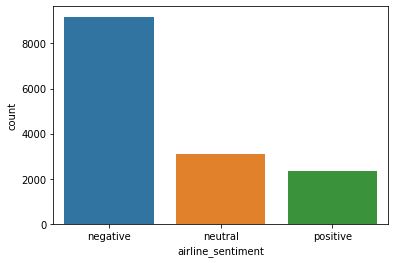

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='airline_sentiment',data= data, order=['negative','neutral','positive'])
plt.show()

we can see that the data classes are imbalanced.

## Preprocessing step

In [9]:
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
data = data[["text","airline_sentiment"]]
data.head(5)

,text,airline_sentiment
4197,"@united Thank you. Yes, I was hoping to speak ...",negative
3435,@united So publicly you asked for details on m...,negative
14011,@AmericanAir DM sent. Answer me please,neutral
11891,@AmericanAir is the new 9:45 time confirmed or...,neutral
10333,@USAirways just hit 4hrs. what is typical wai...,negative


# Data Preparation

In [14]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Data Cleaning

Cleaning the dataset is the most import ant step to provide the ML model with the most important features:

1- we start the cleaning process by removing the stop word, as they do not have any value for predicting the sentiment. 

2- Also, there are special characters(@) to mention different airlines companies, this @ character will be removed and the mentioned company so that the classifier can be used for other companies.

3- There are some words which might indicate a certain sentiment are kept via a whitelist such as not, n't, no.
At last we have to remove the punctuations characters

4- Remove special characters e.g. /, : + etc.

In [15]:

#remove link starts with https
data['text'] = data['text'].map(lambda x:re.sub('http.*','',str(x)))
#removing data and time (numeric values)
data['text'] = data['text'].map(lambda x:re.sub('[0-9]','',str(x)))

#removing special characters
data['text'] = data['text'].map(lambda x:re.sub("[#|*|$,|:|\\|&?!./()+]",' ',str(x)))

In [16]:
data.head()

,text,airline_sentiment
4197,@united Thank you Yes I was hoping to speak ...,negative
3435,@united So publicly you asked for details on m...,negative
14011,@AmericanAir DM sent Answer me please,neutral
11891,@AmericanAir is the new time confirmed or it...,neutral
10333,@USAirways just hit hrs what is typical wait...,negative


Clean the data from all the stop words (the words that are repeated frequently in English), except the words that invert the meaning (whitelist)

In [17]:
from nltk.corpus import stopwords
import string

def clean_data(input_data):
    stopwords_list = stopwords.words('english')
    whitelist = ['not',"n't","no"]    
    words = input_data.split()
    clean_words = [word for word in words if(word not in stopwords_list or word in whitelist) and len(word)>1]
    return " ".join(clean_words)


# this function removes the airline company name after the @ character
def remove_mentions(input_text):
        return re.sub(r'@\w+', '', input_text)


In [18]:
data.text = data.text.apply(clean_data).apply(remove_mentions)
data.head()

,text,airline_sentiment
4197,Thank Yes hoping speak someone directly appre...,negative
3435,So publicly asked details flt Sent DM like as...,negative
14011,DM sent Answer please,neutral
11891,new time confirmed may get Cancelled Flightle...,neutral
10333,hit hrs typical wait time right drive hm airp...,negative


**Splitting the data into training and testing datasets**

The train-test split procedure is used to estimate the performance of machine learning algorithms when they are used to make predictions on data not used to train the model.


In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.text, data.airline_sentiment,test_size=0.2)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 11712
# Test data samples: 2928


In [24]:
X_train = list(X_train)
X_test = list(X_test)
print(len(X_train))
print(X_train[0])

11712
 thanks canned reply


In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

# use tfidf vectorizer to transform the corpus
tfvectorizer = TfidfVectorizer(ngram_range=(1,2), lowercase = True).fit(X_train)
X_train_features = tfvectorizer.transform(X_train)
X_test_features = tfvectorizer.transform(X_test)


#preparing target variable
y_train_labels = y_train.map({'neutral':1,'negative':2,'positive':0})
y_test_labels = y_test.map({'neutral':1,'negative':2,'positive':0})

print(X_test_features.shape)
print(X_train_features.shape)
print(type(X_test_features))

(2928, 79629)
(11712, 79629)
<class 'scipy.sparse.csr.csr_matrix'>


## Import and train a logistic regression model

In [42]:
#training with Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score


clf = LogisticRegression(class_weight = "balanced", max_iter=500, random_state=22)
clf.fit(X_train_features, y_train_labels)
predicted = clf.predict(X_test_features)


acc = accuracy_score(predicted,y_test_labels)
print("Logistic Regression Model Accuray: ", acc)

Logistic Regression Model Accuray:  0.7834699453551912


###  Evaluate the model performance with various techniques

In [43]:
from sklearn.metrics import recall_score, precision_score, f1_score

R_score = recall_score(predicted,y_test_hot_vector,average='weighted')
P_score = precision_score(predicted,y_test_hot_vector,average='weighted')
f1_score = f1_score(predicted,y_test_hot_vector,average='weighted')

print(R_score)
print(P_score)
print(f1_score)

0.7834699453551912
0.7809032824609087
0.7820407492917065
